Things included in this notebook:


In [232]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.curves import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

import make_figures_great_again

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats.stats import pearsonr, mannwhitneyu, ttest_ind
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency, mannwhitneyu
from scipy.special import gamma as gammaf
from sklearn.decomposition import PCA
from sklearn import linear_model
from collections import Counter
import statsmodels.api as sm
import matplotlib.patches as patches
import numpy as np
import scipy as sp
import os
import mpld3
import palettable

sig_level = 0.05

# File locations
faculty_file = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/faculty_cs_CURRENT.txt'
inst_file = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/inst_cs_CURRENT.txt'
figures_dir = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/notebooks-productivity/figures/'
nces_table = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/nces_table.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/profiles_DBLP_Nov16/'

In [233]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)

## Fill in features for all faculty.

In [491]:
total_profiled = 0
min_pubs = 1

for person in asst_faculty:
    N = 0  # How many years to base our predictions on.
    pub_years = []
    start_year = person.first_asst_job_year
    career_length = 2012 - start_year
    person['flag'] = False
    
    if career_length < N or 'dblp_pubs' not in person:
        continue 
        
    # When and where did they receive tenure?
    tenured_in = None
    tenured_at = None
    for job in person['faculty']:
        if job['rank'] in ['Associate Professor', 'Full Professor']:
            if job['start_year'] is not None and (tenured_in is None or job['start_year'] < tenured_in):
                tenured_in = job['start_year'] - start_year
                tenured_at = job['place']
    person['tenured_in'] = tenured_in
    person['tenured_at'] = tenured_at
    
    # Count and categorize their publications:
    pub_years_f = []
    pub_years_m = []
    pub_years_l = []
    
    for pub in person['dblp_pubs']:
        last_name = person.facultyName.split()[-1].lower()
        if pub['pub_type'] in ['inproceedings', 'article'] and pub['year'] is not None \
           and pub['year'] < 2012 and pub['year'] >= start_year:
            if pub['author_role'] == FAP:
                pub_years_f.append(pub['year'] - start_year)
            elif pub['author_role'] == LAP:
                pub_years_l.append(pub['year'] - start_year)
            else:
                pub_years_m.append(pub['year'] - start_year)

    pub_counter_f = Counter(pub_years_f)
    pub_counts_f = np.array([pub_counter_f[y] for y in xrange(career_length)])
    pub_counter_m = Counter(pub_years_m)
    pub_counts_m = np.array([pub_counter_m[y] for y in xrange(career_length)])
    pub_counter_l = Counter(pub_years_l)
    pub_counts_l = np.array([pub_counter_l[y] for y in xrange(career_length)])
    if count_MAP:
        pub_counts = np.array(pub_counts_f + pub_counts_m + pub_counts_l, dtype=np.float)
    else:
        pub_counts = np.array(pub_counts_f + pub_counts_l, dtype=np.float)
    
    if np.sum(pub_counts) < min_pubs:
        continue 
    
    for y in xrange(career_length):
        pub_counts[y] *= conv(start_year+y)
        
    tmax = np.argmax(pub_counts)
    person['tmax'] = tmax
    person['career_length'] = career_length
    person['flag'] = True
    total_profiled += 1
    
print 'Profiled %d faculty!' % (total_profiled)

Profiled 2377 faculty!


In [492]:
# White to orange
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
r,g,b = ACCENT_COLOR_1
cdict = {'red':   ((0.0,  1.0, 1.0),
                   (1.0,  r, r)),
         'green': ((0.0,  1.0, 1.0),
                   (1.0,  g, g)),
         'blue':  ((0.0,  1.0, 1.0),
                   (1.0,  b, b))}

# white to orange to black
cdict = {'red':   ((0.0,  1, 1),
                   (0.5,  r, r),
                   (1.0,  0, 0)),
         'green': ((0.0,  1, 1),
                   (0.5,  g, g),
                   (1.0,  0, 0)),
         'blue':  ((0.0,  1, 1),
                   (0.5,  b, b),
                   (1.0,  0, 0))}

tempcamp = LinearSegmentedColormap('testcmap', cdict)
plt.register_cmap(cmap=tempcamp)

In [493]:
tempcamp(.7)

(0.59607843137254901, 0.33894655901576315, 0.11220299884659746, 1.0)

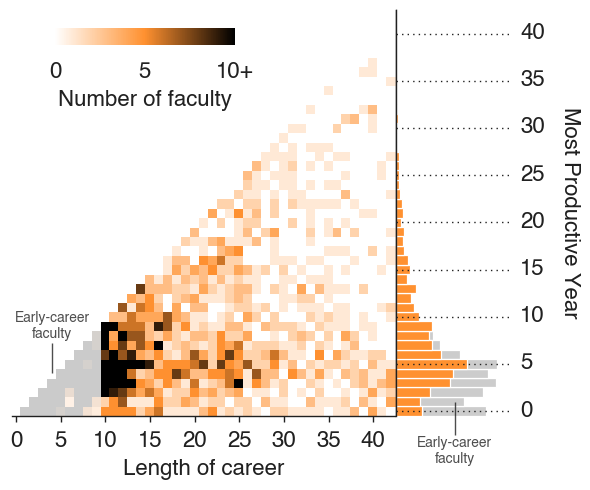

In [522]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

max_duration = 43
X = np.zeros((max_duration,max_duration), dtype=float)
marginal = np.zeros(max_duration, dtype=float)
marginal_ex = np.zeros(max_duration, dtype=float)
for person in asst_faculty:
    if person['flag']:
        X[person['career_length']][person['tmax']] += 1
        if person['career_length'] >= 10:
            marginal[person['tmax']] += 1
        else:
            marginal_ex[person['tmax']] += 1
        
#for i, v in enumerate(X.sum(axis=1)):
#    if v == 0: continue 
#    X[i,:] /= v

plt.set_cmap(tempcamp)
#plt.set_cmap(palettable.colorbrewer.sequential.YlOrBr_9.mpl_colormap) 
#plt.set_cmap(palettable.cubehelix.red_16.mpl_colormap)
cax = ax.pcolor(X.transpose(), vmin=0, vmax=10)

divider = make_axes_locatable(ax)
ax2 = divider.append_axes("right", size=1.15, pad=0, sharey=ax)
total = np.sum(marginal)
total_ex = np.sum(marginal_ex)
total_all = total + total_ex
marginal_all = marginal + marginal_ex

ticks = np.arange(9) * 5 + 0.5
for t in ticks:
    ax2.plot([0, 300], [t,t], ':', color=ALMOST_BLACK)
    
ax2.barh(xrange(max_duration), marginal_all, lw=0.9, color=LIGHT_COLOR, edgecolor='w', height=1.)
ax2.barh(xrange(max_duration), marginal, lw=0.9, color=ACCENT_COLOR_1, edgecolor='w', height=1.)
finalize(ax2, fontsize=16)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.set_xticks([])
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_ylabel('Most Productive Year',rotation=270,labelpad=10)
#ax2.spines["left"].set_visible(False)
#ax2.set_xlim(0, 13)

plt.setp(ax2.get_xticklabels(), visible=False)

ax.set_xlabel('Length of career')
#ax2.yaxis.tick_right()
#ax2.yaxis.label_position = 'right'

finalize(ax, fontsize=16)
xticks = np.arange(0,9)*5
ax.set_xticks(xticks+0.5)
ax.set_xticklabels(xticks)
ax.set_yticks(xticks+0.5)

ax.set_yticklabels(xticks, ha='center')
ax.tick_params(axis='y', direction='out', pad=13.75)

ax.yaxis.tick_right()
ax.yaxis.label_position = 'right'
ax.yaxis.labelpad = 25
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(False)
ax.set_xlim(0,max_duration)
ax.set_ylim(0,max_duration)

#fig, ax = plt.subplots(figsize=(6,0.3))

ax_cb = plt.axes([.1, .9, .3, .035], axisbg='y')
norm = mpl.colors.Normalize(vmin=0, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=tempcamp, orientation='horizontal', norm=norm)
cb1.set_ticks([0, .1, .1999])
cb1.set_ticklabels(['0', '5', '10+'])
cb1.set_label('Number of faculty', fontsize=LABEL_SIZE+2)
cb1.ax.tick_params(labelsize=LABEL_SIZE+2, direction='out', length=0) 
cb1.outline.set_visible(False)

ax.add_patch(
    patches.Rectangle(
        (0.5, 0),   # (x,y)
        9.5,          # width
        10,          # height
        color='w', alpha=0.8, edgecolor='None', linewidth=0
    )
)

ax2.add_patch(
    patches.Rectangle(
        (0.1, -1.0),   # (x,y)
        200,          # width
        1,          # height
        color='w', clip_on=False, edgecolor='None', linewidth=0
    ), 
)


ax2.plot([155, 155], [-2, 1.5], '-', color=ALMOST_BLACK, lw=1, clip_on=False, alpha=0.8)
ax2.text(155, -5, 'Early-career\nfaculty', ha='center', alpha=0.8, color=ALMOST_BLACK)

ax.plot([4.5, 4.5], [7.75, 4.5], '-', color=ALMOST_BLACK, lw=1, clip_on=False, alpha=0.8)
ax.text(4.5, 9.5, "Early-career\nfaculty", rotation=0, ha='center', va='center', alpha=0.8, color=ALMOST_BLACK)
ax2.set_yticks(ticks)
ax2.yaxis.tick_right()
ax2.yaxis.label_position = 'right'

#plt.savefig(figures_dir + 'most_prod_colorbar.pdf', bbox_inches='tight') 
#plt.show()

plt.savefig(figures_dir + 'most_prod_year_NONORM.pdf')
plt.show()

## Piecewise linear fits

In [366]:
skip_until = 0

Tao Jiang


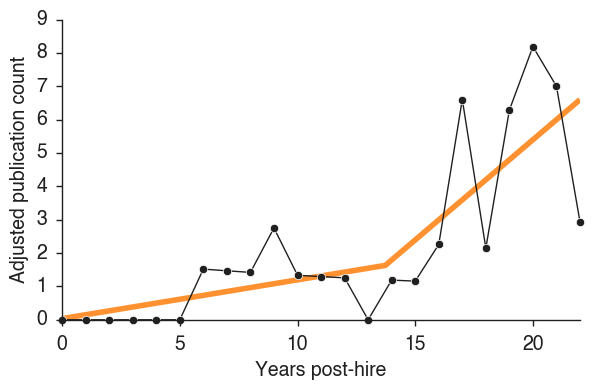

AssertionError: 

In [380]:
total_profiled = 0
min_pubs = 3
min_career_length = 10
smoothing = False
count_MAP = False

# Plotting variables
printing = True
skipped = 0

for person in asst_faculty:
    pub_years = []
    start_year = person.first_asst_job_year
    career_length = 2012 - start_year
    person['flag'] = False
    
    if career_length < min_career_length or 'dblp_pubs' not in person:
        continue 
        
    if start_year > 2001 or start_year < 1986:
        continue
        
    # When and where did they receive tenure?
    tenured_in = None
    tenured_at = None
    for job in person['faculty']:
        if job['rank'] in ['Associate Professor', 'Full Professor']:
            if job['start_year'] is not None and (tenured_in is None or job['start_year'] < tenured_in):
                tenured_in = job['start_year'] - start_year
                tenured_at = job['place']
    person['tenured_in'] = tenured_in
    person['tenured_at'] = tenured_at
        
    # Count and categorize their publications:
    pub_years_f = []
    pub_years_m = []
    pub_years_l = []
    
    for pub in person['dblp_pubs']:
        if pub['pub_type'] in ['inproceedings', 'article'] and pub['year'] is not None \
           and pub['year'] < 2012 and pub['year'] >= start_year:
            if pub['author_role'] == FAP:
                pub_years_f.append(pub['year'] - start_year)
            elif pub['author_role'] == LAP:
                pub_years_l.append(pub['year'] - start_year)
            elif pub['author_role'] == MAP:
                pub_years_m.append(pub['year'] - start_year)
            else:
                raise ValueError('Invalid author_role')

    pub_counter_f = Counter(pub_years_f)
    pub_counts_f = np.array([pub_counter_f[y] for y in xrange(career_length)])
    pub_counter_m = Counter(pub_years_m)
    pub_counts_m = np.array([pub_counter_m[y] for y in xrange(career_length)])
    pub_counter_l = Counter(pub_years_l)
    pub_counts_l = np.array([pub_counter_l[y] for y in xrange(career_length)])

    if count_MAP:
        pub_counts = np.array(pub_counts_f + pub_counts_m + pub_counts_l, dtype=np.float)
    else:
        pub_counts = np.array(pub_counts_f + pub_counts_l, dtype=np.float)
    
    if np.sum(pub_counts) < min_pubs:
        continue 
        
    if len(np.where(pub_counts > 0)[0]) < min_pubs:
        continue
        
    # Control for inflation:
    for y in xrange(career_length):
        pub_counts[y] *= conv(start_year+y)
    
    p0 = np.array([len(pub_counts)/2., 0., 0., 0.])
    p = fit_piecewise_linear(np.arange(len(pub_counts)), pub_counts, piecewise_linear1, p0)
    
    if printing:
        prms = unpack_params(p)
        if not (prms['m1'] > 0 and prms['m2'] > 0):
            continue 
        
        skipped += 1
        if skipped < skip_until:  # Skip until after ___ 
            continue 
        fig, ax = plt.subplots(1,1,figsize=SINGLE_FIG_SIZE)
        #ax.set_title(person.facultyName)
        ax.plot(pub_counts, '-o', color=ALMOST_BLACK, clip_on=False, markeredgecolor='w')
        x_plot = np.linspace(0, len(pub_counts)-1, 200*len(pub_counts))
        ax.plot(x_plot, piecewise_linear1(x_plot, *p), '-', color=ACCENT_COLOR_1, lw=4, alpha=1, clip_on=True, zorder=-100)
        print person.facultyName
        params = unpack_params(p)
        
        finalize(ax)
        ax.set_xlim(0, len(pub_counts)-1)
        #ax.set_ylim(0, 9)
        ax.set_xlabel('Years post-hire')
        ax.set_ylabel('Adjusted publication count')
        plt.savefig(figures_dir + 'example_fit.pdf')
        plt.show()
        skip_until += 1

        
        assert(False)  # BREAK
        
    params = unpack_params(p)
        
    person['pubmax'] = np.max(pub_counts)
    person['tmax'] = np.argmax(pub_counts)
    person['career_length'] = career_length
    
    person['b1'] = params['b1']
    person['m1'] = params['m1']
    person['m2'] = params['m2']
    person['tstar'] = params['tstar']
    person['flag'] = True
    person['p'] = p
    total_profiled += 1
    
print 'Profiled %d faculty!' % (total_profiled)

In [219]:

skip_until -= 1


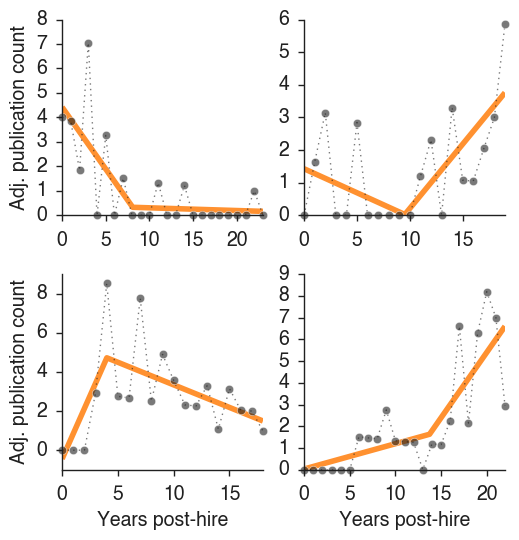

In [489]:
fig, axs = plt.subplots(2,2,figsize=(5.25,5.5))
names = ['Rodney R. Howell', 'Mike MacGregor','Edward Felten', 'Tao Jiang'] #Adrian Sandu']
inds = [(0,0), (0,1), (1,0), (1,1)]
found = 0

for person in asst_faculty:
    if person.facultyName in names:
        idx = names.index(person.facultyName)
        i,j = inds[idx]
        ax = axs[i][j]
            
        pub_years = []
        start_year = person.first_asst_job_year
        career_length = 2012 - start_year
        
        # Count and categorize their publications:
        pub_years_f = []
        pub_years_m = []
        pub_years_l = []

        for pub in person['dblp_pubs']:
            if pub['pub_type'] in ['inproceedings', 'article'] and pub['year'] is not None \
               and pub['year'] < 2012 and pub['year'] >= start_year:
                if pub['author_role'] == FAP:
                    pub_years_f.append(pub['year'] - start_year)
                elif pub['author_role'] == LAP:
                    pub_years_l.append(pub['year'] - start_year)
                elif pub['author_role'] == MAP:
                    pub_years_m.append(pub['year'] - start_year)
                else:
                    raise ValueError('Invalid author_role')

        pub_counter_f = Counter(pub_years_f)
        pub_counts_f = np.array([pub_counter_f[y] for y in xrange(career_length)])
        pub_counter_m = Counter(pub_years_m)
        pub_counts_m = np.array([pub_counter_m[y] for y in xrange(career_length)])
        pub_counter_l = Counter(pub_years_l)
        pub_counts_l = np.array([pub_counter_l[y] for y in xrange(career_length)])

        if count_MAP:
            pub_counts = np.array(pub_counts_f + pub_counts_m + pub_counts_l, dtype=np.float)
        else:
            pub_counts = np.array(pub_counts_f + pub_counts_l, dtype=np.float)
            
            # Control for inflation:
        for y in xrange(career_length):
            pub_counts[y] *= conv(start_year+y)

        p0 = np.array([len(pub_counts)/2., 0., 0., 0.])
        p = fit_piecewise_linear(np.arange(len(pub_counts)), pub_counts, piecewise_linear1, p0)

        ax.plot(pub_counts, ':o', color=ALMOST_BLACK, clip_on=False, markeredgecolor='w', alpha=0.6)
        x_plot = np.linspace(0, len(pub_counts)-1, 200*len(pub_counts))
        ax.plot(x_plot, piecewise_linear1(x_plot, *p), '-', color=ACCENT_COLOR_1, lw=4, alpha=1, clip_on=True, zorder=-100)
        
        finalize(ax)
        ax.set_xticks([0, 5, 10, 15, 20])
        ax.set_xlim(0, len(pub_counts)-1)
        if i == 1:
            ax.set_xlabel('Years post-hire')
        if j == 0:
            ax.set_ylabel('Adj. publication count')
        #
        #plt.show()

plt.savefig(figures_dir + 'example_fits.pdf')
plt.show()

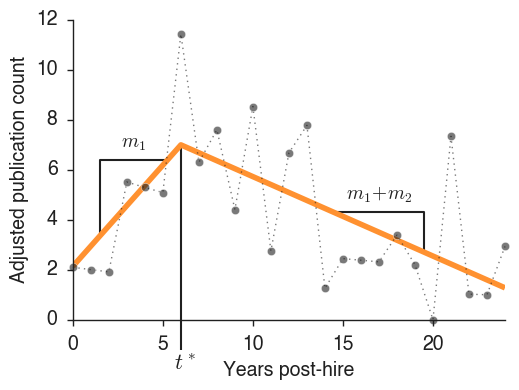

In [488]:
fig, ax = plt.subplots(1,1,figsize=(5.25,4))
names = ['Jack H. Lutz']
found = 0

for person in asst_faculty:
    if person.facultyName in names:     
        pub_years = []
        start_year = person.first_asst_job_year
        career_length = 2012 - start_year
        
        # Count and categorize their publications:
        pub_years_f = []
        pub_years_m = []
        pub_years_l = []

        for pub in person['dblp_pubs']:
            if pub['pub_type'] in ['inproceedings', 'article'] and pub['year'] is not None \
               and pub['year'] < 2012 and pub['year'] >= start_year:
                if pub['author_role'] == FAP:
                    pub_years_f.append(pub['year'] - start_year)
                elif pub['author_role'] == LAP:
                    pub_years_l.append(pub['year'] - start_year)
                elif pub['author_role'] == MAP:
                    pub_years_m.append(pub['year'] - start_year)
                else:
                    raise ValueError('Invalid author_role')

        pub_counter_f = Counter(pub_years_f)
        pub_counts_f = np.array([pub_counter_f[y] for y in xrange(career_length)])
        pub_counter_m = Counter(pub_years_m)
        pub_counts_m = np.array([pub_counter_m[y] for y in xrange(career_length)])
        pub_counter_l = Counter(pub_years_l)
        pub_counts_l = np.array([pub_counter_l[y] for y in xrange(career_length)])

        if count_MAP:
            pub_counts = np.array(pub_counts_f + pub_counts_m + pub_counts_l, dtype=np.float)
        else:
            pub_counts = np.array(pub_counts_f + pub_counts_l, dtype=np.float)
            
            # Control for inflation:
        for y in xrange(career_length):
            pub_counts[y] *= conv(start_year+y)

        p0 = np.array([len(pub_counts)/2., 0., 0., 0.])
        p = fit_piecewise_linear(np.arange(len(pub_counts)), pub_counts, piecewise_linear1, p0)
        params = unpack_params(p)

        ax.plot(pub_counts, ':o', color=ALMOST_BLACK, clip_on=False, markeredgecolor='w', alpha=0.6)
        x_plot = np.linspace(0, len(pub_counts)-1, 200*len(pub_counts))
        ax.plot(x_plot, piecewise_linear1(x_plot, *p), '-', color=ACCENT_COLOR_1, lw=4, alpha=1, clip_on=True, zorder=-100)
        
        x_p = np.array([1.5, 1.5, 5.25])
        y_p = piecewise_linear1(x_p, *p)
        y_p[1] = y_p[-1]
        mid_x = (x_p[0] + x_p[-1])/2.
        ax.text(mid_x, y_p[-1] + .5, r'$m_1$', ha='center', fontsize=LABEL_SIZE)
        ax.plot(x_p, y_p, '-', lw=1.5, color=ALMOST_BLACK, zorder=-1000)
        
        x_p = np.array([14.5, 19.5, 19.5])
        y_p = piecewise_linear1(x_p, *p)
        y_p[1] = y_p[0]
        mid_x = (x_p[0] + x_p[-1])/2.
        ax.text(mid_x, y_p[0] + .5, r'$m_1\!+\!m_2$', ha='center', fontsize=LABEL_SIZE)
        ax.plot(x_p, y_p, '-', lw=1.5, color=ALMOST_BLACK, zorder=-1000)
        
        x_p = 2*[params['tstar']]
        y_p = [-1.2, piecewise_linear1(params['tstar'], *p)]
        ax.plot(x_p, y_p, '-', lw=1.5, color=ALMOST_BLACK, zorder=-1000, clip_on=False)
        ax.text(x_p[0]+.25, -2, r'$t^*$', ha='center', fontsize=LABEL_SIZE + 2)
        
        finalize(ax)
        ax.set_xticks([0, 5, 10, 15, 20])
        ax.set_xlim(0, len(pub_counts)-1)
        ax.set_ylim(0, 12)
        ax.set_xlabel('Years post-hire')
        ax.set_ylabel('Adjusted publication count')
        #
        #plt.show()

plt.savefig(figures_dir + 'example_fit.pdf')
plt.show()